# Deep Learning on Graph Data:

In this presentation we use Tensorflow to detect fraudulent graph structures. 

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools as it
import random

from scipy.misc import logsumexp

In [2]:
# create new session if we need it
sess = tf.Session()

In [3]:
def generate_graphs(n, min_nodes=10, max_nodes=200, y=1):
    # Code to generate n random graphs
    
    graphset = []
    
    for i in range(n):

        # Assigning number of nodes randomly between 1-200
        n_nodes = random.randint(min_nodes,max_nodes)
        
        # Modelling the resource allocation with Normal Distrib - mean: m, and stddev = s
        p = 0.2       
        m = 20
        s = 0.25

#         G_rand = nx.duplication_divergence_graph(n_nodes, p, 1, directed=True)
#         G_rand = nx.gnr_graph(n_nodes,p)
#         G_rand = nx.powerlaw_cluster_graph(n_nodes,4,0.1)
        G_rand = nx.gnc_graph(n_nodes)
    
        # make sure all nodes have outdegree of at least 1
        outds = G_rand.out_degree().values()
        for i, outd in enumerate(outds):
            if outd == 0 or y != 1:
                valid_inds = range(0,i) +\
                                    range(i+1,n_nodes)
#                 print i, valid_inds
                G_rand.add_edge(i, 
                                random.choice(valid_inds))

        graphset.append(G_rand)
    
    return graphset

In [4]:
def displayGraph(graph):
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph, pos)
    nx.draw_networkx_edges(graph, pos, arrows=True)
    nx.draw_networkx_labels(graph,pos)
    plt.title('Graphs generated')
    plt.show()

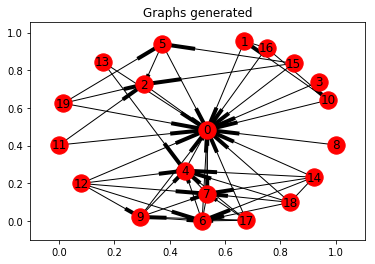

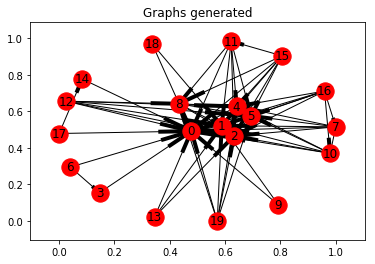

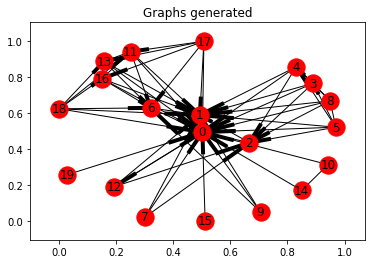

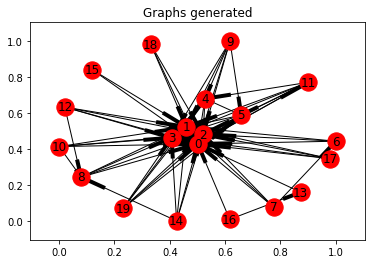

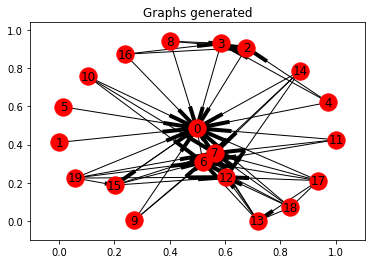

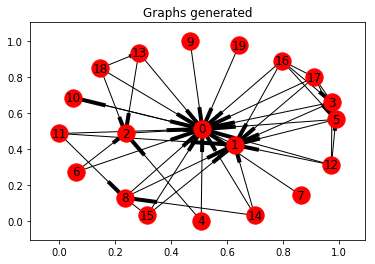

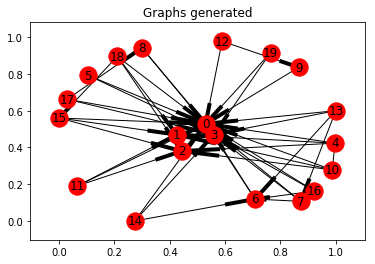

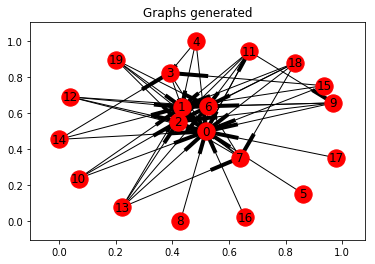

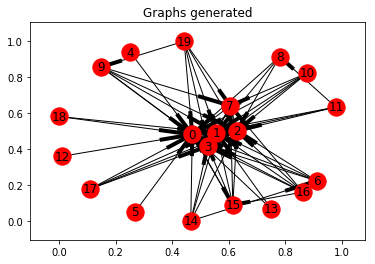

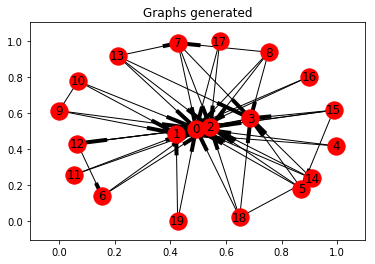

In [19]:
# generate some graphs
n = 10
graphset = generate_graphs(n, min_nodes=20, 
                           max_nodes=20,y=1)

# Printing the graphs:
for graph in graphset:
    displayGraph(graph)

In [6]:
def pageRank_allocation(G):
    
    # Calculate PageRank here
    pr = nx.pagerank(G)
    
    # Assign PageRank values here
    for i in G:
        node = G.node[i]
        page_rank_value = pr[i]
        node['PageRank'] = tf.constant(page_rank_value)
        node['pr'] = pr[i]
    return pr.values()

In [21]:
# After crosschecking for one graph doing for all the graphs
count = 0

for i in range(len(graphset)):
    pr = pageRank_allocation(graphset[i])
    for p in pr:
#         print ' ',p
        pass
    print 'Allocating Pagerank score for Graph:', i,\
        logsumexp(np.array(pr))



Allocating Pagerank score for Graph: 0 3.05024634815
Allocating Pagerank score for Graph: 1 3.051152136
Allocating Pagerank score for Graph: 2 3.05002541997
Allocating Pagerank score for Graph: 3 3.04871086083
Allocating Pagerank score for Graph: 4 3.04949093142
Allocating Pagerank score for Graph: 5 3.05341719647
Allocating Pagerank score for Graph: 6 3.05371869523
Allocating Pagerank score for Graph: 7 3.04917772689
Allocating Pagerank score for Graph: 8 3.04911428462
Allocating Pagerank score for Graph: 9 3.0501142363


In [129]:
G = graphset[0]

for i in G:
    print i, sess.run(G.node[i]['PageRank'])

0 0.2987
1 0.01125
2 0.0353184
3 0.0224303
4 0.0174782
5 0.014415
6 0.0123205
7 0.00981203
8 0.00789474
9 0.00789474
10 0.00789474
11 0.11617
12 0.0815232
13 0.063525
14 0.00789474
15 0.00789474
16 0.00789474
17 0.261794
18 0.00789474


In [137]:
# At this stage you have a list of Graphs containing random nodes from 1-200
# Each node has a tensorFlow constant value attached to it signifying its PageRank score

# first calc K, A, M
def pagerank(graph, damping=0.85):
    N = nx.number_of_nodes(graph)
    A = nx.to_numpy_matrix(graph)
    k = graph.out_degree().values()
    K = np.diag(k)
    M = (np.matmul(np.linalg.inv(K),A)).T
    R = np.matmul(np.linalg.inv(np.identity(N) - damping*M),\
        (1.0 - damping)/N * np.ones((N,1)))
    
    for i in graph.node:
        print R[i], graph.node[i]['pr']
    

    
pagerank(graphset[0])

[[ 0.29870093]] 0.298700079403
[[ 0.01125]] 0.01125
[[ 0.03531844]] 0.035318436029
[[ 0.0224303]] 0.0224302967516
[[ 0.01747815]] 0.017478153313
[[ 0.01441497]] 0.0144149718045
[[ 0.01232049]] 0.0123204887218
[[ 0.00981203]] 0.00981203007519
[[ 0.00789474]] 0.00789473684211
[[ 0.00789474]] 0.00789473684211
[[ 0.00789474]] 0.00789473684211
[[ 0.11617175]] 0.116170470575
[[ 0.08152404]] 0.0815232485216
[[ 0.06352522]] 0.0635250013973
[[ 0.00789474]] 0.00789473684211
[[ 0.00789474]] 0.00789473684211
[[ 0.00789474]] 0.00789473684211
[[ 0.26179053]] 0.261793665513
[[ 0.00789474]] 0.00789473684211


In [33]:
def gen_test1():
    n = 10
    thresh = 3.05
    graphs = generate_graphs(n, min_nodes=20, 
                           max_nodes=20,y=1) +\
             generate_graphs(n, min_nodes=20, 
                           max_nodes=20,y=-1) 
    As = []
    ys = []
    ks = []
    
    for graph in graphs:
        pr = pageRank_allocation(graph)

        score = logsumexp(np.array(pr))
        if score > thresh:
            ys.append(1)
        else:
            ys.append(-1)
        
        
        As.append(nx.to_numpy_matrix(graph))
        ks.append(graph.out_degree().values())
        
    return As, ys, ks, graphs
        
As, ys, ks, graphs = gen_test1()

In [37]:
def tf_pagerank(n, damping=0.85):
#     N = nx.number_of_nodes(graph)
#     A = nx.to_numpy_matrix(graph)
#     k = graph.out_degree().values()
    d = tf.constant(damping)
    N = tf.constant(n, dtype=tf.float32)
    A = tf.placeholder(tf.float32, shape=(n,n))
    k = tf.placeholder(tf.float32, shape=(n,))
    kinv = tf.div(tf.ones((n,), tf.float32), k)
    Kinv = tf.diag(kinv)
    I2 = tf.eye(n)
    M = tf.transpose(tf.matmul(Kinv, A))
    Minv = tf.matrix_inverse(I2 - d*M)
    R = tf.matmul(Minv,\
        tf.multiply((1.0 - damping)/N, tf.ones((n,1))))
    
    return R, A, k

In [39]:
def opt_pgrank(As, ys, ks):
    thresh = tf.Variable(0.0, name='threshold')
    R, A, k = tf_pagerank(20)
    y = tf.placeholder(tf.float32, shape=())
    
    cost = tf.multiply(y, (thresh - tf.reduce_logsumexp(R)))
    
#     optimizer = tf.train.GradientDescentOptimizer(0.1)
#     trainer = optimizer.minimize(cost)
    
    # get things ready
    sess.run(tf.global_variables_initializer())
    
    n = 20
    damping = 0.85
    
    print sess.run(cost, feed_dict={A : As[0], y : ys[0], k : ks[0]})
    
    
    
    

    
#     epochs = 30
#     loss = []
#     thresh_hist = []
#     for epoch in range(epochs):
#         for i in range(len(ys)):
#             sess.run(trainer, feed_dict={A : As[i], y : ys[i], k : ks[i]})
#             loss.append(sess.run(cost, feed_dict={X : x}))
#             thresh_hist.append(sess.run(thresh, feed_dict={A : As[i], y : ys[i], k : ks[i]}))
#         plt.plot(loss)
#         plt.show()
        
opt_pgrank(As, ys, ks)

-3.05004
